# HW 3 - PCA Guide

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets

In [2]:
def load_MNIST_data(data_path, fashion=False, quiet=False):
    if not fashion:
        train_set = datasets.MNIST(data_path, download=True, train=True)
        test_set = datasets.MNIST(data_path, download=True, train=False)
    else:
        train_set = datasets.FashionMNIST(data_path, download=True, train=True)
        test_set = datasets.FashionMNIST(data_path, download=True, train=False)      
    x_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
    N_train, H, W = x_train.shape
    N_test, H, W = x_test.shape

    if not quiet:
        print(f'The data are {H} x {W} grayscale images.')
        print(f'N_train = {N_train}')
        print(f'N_test = {N_test}')
    for i in set(y_train):
        N_i_train = np.sum(y_train==i)
        N_i_test = np.sum(y_test==i)
        if not quiet:
            print(f'Class {i}: has {N_i_train} train images ({100 * N_i_train / N_train : .2f} %), {N_i_test} test images ({100 * N_i_test/ N_test : .2f} %) ')
    return x_train, y_train, x_test, y_test

## Accessing and Inspecting the Data
First, let's get a function to get the MNIST or FMNIST data.

In [3]:
USE_FASHION_MNIST = True

x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=USE_FASHION_MNIST, quiet=False)


if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    tag_name = 'MNIST'
    label_names = [f'{i}' for i in set(y_test)]

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

The data are 28 x 28 grayscale images.
N_train = 60000
N_test = 10000
Class 0: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 1: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 2: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 3: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 4: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 5: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 6: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 7: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 8: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 
Class 9: has 6000 train images ( 10.00 %), 1000 test images ( 10.00 %) 


<Figure size 640x480 with 0 Axes>

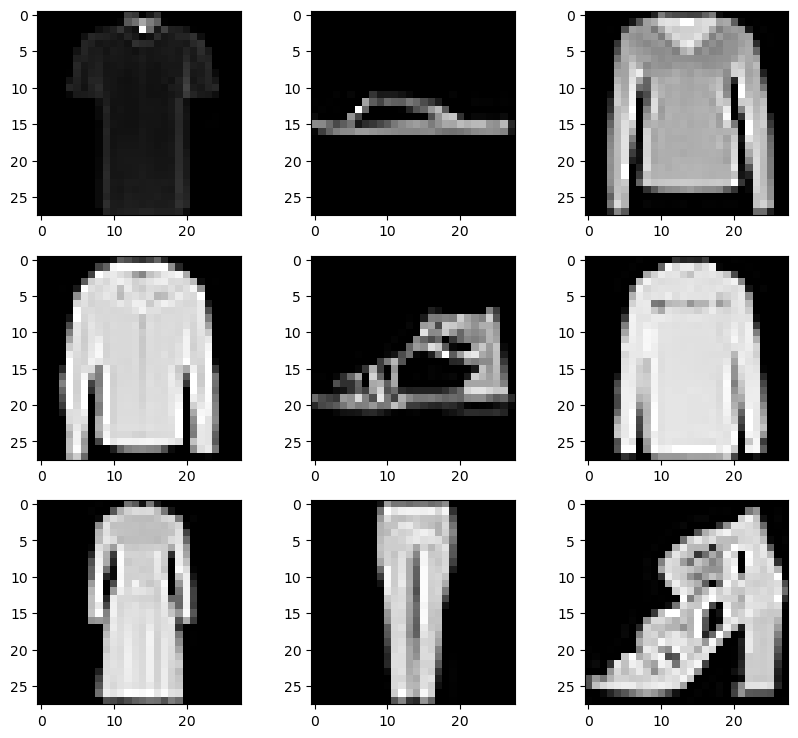

In [4]:
plt.gray() # B/W Images
plt.figure(figsize = (10,9)) # Adjusting figure size
# Displaying a grid of 3x3 images
for i in range(9):
    index = np.random.randint(low=0, high=len(y_train), dtype=int)
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[index])
plt.show()

## Least Squares Multiclass Classification
Fist, define a couple helper functions.

In [5]:
def flatten_and_augment(x):
    N, H, W = x.shape
    D = H * W
    x_aug = np.ones((N, D + 1))
    x_aug[:, 1:] = x.reshape((N, D))
    return x_aug

def create_target_matrix(labels):
    label_vals = list(set(labels))
    C = len(label_vals)
    N = len(labels)
    y = -1 * np.ones((N, C)) 
    for n in range(N):
        y[n][labels[n]] = +1
    return y

We can use these to get augment the data (add the 1s) and then flatten.  Then, we create the target matrix ${\bf Y}$ which is a $(N \times C)$ matrix.  The $n^{th}$ row of this matrix has the correct class labels for the $n^{th}$ data point.  We adopt the convention that this is $-1$ at all columns (classes) except the correct class, for which it is $+1$.

After solving the MSE regression with these ${\bf Y}$ targets, we classify by maximizing over $g_m({\bf x}) = {\bf w}_m {\bf x}$.  This can be viewed as doing a one-vs-rest (OvR) approach where each of the $C$ classifiers are designed as binary MSE classifiers, then using the fushion/decision rule of choosing the max.  Alternatively, it is a Maximal Value Method (MVM) where the weight vectors are optimized with the MSE criterion and the multiclass targets.  

We will use the `np.linalg.lstsq()` routine to solve the MSE regression problem.  This is the pseudo-inverse appoach, not gradient descent!
The `np.linalg.lstsq()` routine can handle passing the matrix targets ${\bf Y}$ instead of vector targets ${\bf y}_c$ -- i.e., the $c$-th column of ${\bf Y}$.  One call with a matrix of targets is equivalent to $C$ calls with the associated vectors targets $\{{\bf y}_c\}_{c=1}^C$.

* PCA dimension Reduction

You need to perform PCA to get a reduced dimension of the training data. Following that, you would need to augment your training and test data, and find W_hat. You need to report the accuracy based on the obtained weights.

A plot of the accuracy vs. dimension of the input is helpful. Hint: Accuracy increases as we increase the dimension of the input.

The PCA procedure was demonstrated in lecture using NumPY methods, see [8.1_PCA_kMeans_MNIST.ipynb](https://github.com/keithchugg/ee499_ml_spring23/blob/main/8.1_PCA_kMeans_MNIST.ipynb)

In [6]:
x_train_aug = flatten_and_augment(x_train) #x_train need to be the training data with the reduced dimension
x_test_aug = flatten_and_augment(x_test) #x_test is for evaluation of the model once you obtain W_hat
Y = create_target_matrix(y_train)

W_hat = np.linalg.lstsq(x_train_aug, Y, rcond=None)[0]